In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Data Encoding and Scaling
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
# Pipeline
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Natural Language Processing(NLP)
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Word Embedding
import gensim
from gensim.models import Word2Vec

In [3]:
gensim.__version__

'4.3.3'

In [4]:
warnings.filterwarnings('ignore')

In [5]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dushyant\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dushyant\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dushyant\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [7]:
''' Columns to recheck '''
''' premium_plan, jobma_catcher_creation, 
'''

' premium_plan, jobma_catcher_creation, \n'

In [8]:
df = pd.read_csv('data_collection.csv')

In [9]:
df.drop(['subscription_type_x',
         'premium_storage_y',
         'jobma_catcher_sub_accounts',
         'jobma_job_company_profile',
         'jobma_catcher_creation'], axis=1, inplace=True)

In [10]:
df.columns

Index(['jobma_catcher_id', 'credit_amount', 'wallet_amount', 'plan_type',
       'is_unlimited', 'premium_storage_x', 'subscription_amount',
       'credit_given', 'payment_mode', 'status', 'payment_status',
       'number_of_transactions', 'jobma_catcher_company', 'org_type',
       'jobma_catcher_indus', 'jobma_catcher_title', 'jobma_catcher_otype',
       'jobma_catcher_type', 'is_premium', 'jobma_catcher_parent',
       'jobma_catcher_is_deleted', 'jobma_verified', 'data_access',
       'subscription_status', 'interview_rate', 'live_interview_credit',
       'pre_recorded_credit', 'ai_live_interview_credit', 'credit_value',
       'interview_cost_type', 'subscription_type_y', 'phone_call_cost_type',
       'jobma_support_rtc', 'interview_question', 'video_recording_suppport',
       'sing_up_canditate_after_apply', 'referral_credit', 'company_size',
       'jobma_auto_recording_status', 'jobma_scenario_question_status',
       'number_of_kits', 'number_of_invitations', 'jobma_job_t

In [11]:
df['plan_type'].fillna('No', inplace=True)

In [12]:
df['is_unlimited'].fillna('No', inplace=True)

In [13]:
df.shape

(179549, 53)

In [14]:
''' This Function is to fill all missing values (if col is int then 0, if col is float then 0.0 and if col is object then 'Unkmown') '''

def fill_missing_values(df):
    df = df.copy()
    for col in df.columns:
        if df[col].dtype == np.int64:
            df[col] = df[col].fillna(0)
        elif df[col].dtype == np.float64:
            df[col] = df[col].fillna(0.0)
        elif df[col].dtype == object:
            df[col] = df[col].fillna('Unknown')
    return df

In [15]:
for col in df.columns:
    if df[col].dtype == np.int64:
        df[col].fillna(0, inplace=True)
    elif df[col].dtype == np.float64:
        df[col].fillna(0.0, inplace=True)
    elif df[col].dtype == object:
        df[col].fillna('Unknown', inplace=True)

# Data Encoding

In [17]:
df['jobma_job_currency'].unique()

array(['Unknown', 'USD', 'INR', '1', '2', '0', '4', '5', '3', 1.0, 4.0,
       3.0, 2.0, '6', 'string'], dtype=object)

In [18]:
label_encoders = {}
label_col = ['jobma_catcher_company', 'jobma_job_type', 'jobma_job_currency']

def label_encoder(df):
    df = df.copy()  

    for col in label_col:
        if col in df.columns:
            if df[col].dtype == object or df[col].dtype.name == 'category':
                le_col = LabelEncoder()
                df[col] = le_col.fit_transform(df[col].astype(str))
                label_encoders[col] = le_col

    return df

In [19]:
# df['company_size'] = df['company_size'].astype('category')

In [20]:
df['company_size'].dtype

dtype('O')

In [21]:
# def ordinal_encoder(df):
#     df = df.copy()
#     ordinal_col = ['company_size']
#     ordinal_order = ['Unknown', '1-25', '26-100', '101-500', '500-1000', 'More than 1000']

#     ordinal = OrdinalEncoder(categories=[ordinal_order])
#     ordinal_array = ordinal.fit_transform(df[ordinal_col])
#     ordinal_df = pd.DataFrame(ordinal_array, columns=[f'{col}_ord' for col in ordinal_col], index=df.index)
#     df = pd.concat([df, ordinal_df], axis=1)

#     return df

In [22]:
def ordinal_encoder(df):
    df = df.copy()
    ordinal_col = ['company_size']
    
    # Define the order for encoding
    ordinal_order = ['Unknown', '1-25', '26-100', '101-500', '500-1000', 'More than 1000']
    
    # Fit encoder
    ordinal = OrdinalEncoder(categories=[ordinal_order])
    encoded = ordinal.fit_transform(df[ordinal_col].astype(str))
    
    # Create DataFrame from encoded
    encoded_df = pd.DataFrame(encoded, columns=[f'{col}_ord' for col in ordinal_col], index=df.index)
    
    # Drop original string column
    df.drop(columns=ordinal_col, inplace=True)
    
    # Combine with rest
    df = pd.concat([df, encoded_df], axis=1)
    
    return df

In [23]:
def onehot_encoder(df):
    df = df.copy()
    onehot_col = ['plan_type', 'is_unlimited', 'jobma_catcher_is_deleted']

    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_array = ohe.fit_transform(df[onehot_col].astype(str))

    encoded_df = pd.DataFrame(encoded_array, columns=ohe.get_feature_names_out(onehot_col), index=df.index)

    # Drop original and concat encoded
    df.drop(columns=onehot_col, inplace=True)
    df = pd.concat([df, encoded_df], axis=1)
    
    return df

In [24]:
# df[df.astype(str).apply(lambda x: x.str.contains('Unknown', na=False)).any(axis=1)].apply(lambda row: row[row.str.contains('Unknown', na=False)].index.tolist(), axis=1)

**Creating Tags Column**

In [26]:
df.columns

Index(['jobma_catcher_id', 'credit_amount', 'wallet_amount', 'plan_type',
       'is_unlimited', 'premium_storage_x', 'subscription_amount',
       'credit_given', 'payment_mode', 'status', 'payment_status',
       'number_of_transactions', 'jobma_catcher_company', 'org_type',
       'jobma_catcher_indus', 'jobma_catcher_title', 'jobma_catcher_otype',
       'jobma_catcher_type', 'is_premium', 'jobma_catcher_parent',
       'jobma_catcher_is_deleted', 'jobma_verified', 'data_access',
       'subscription_status', 'interview_rate', 'live_interview_credit',
       'pre_recorded_credit', 'ai_live_interview_credit', 'credit_value',
       'interview_cost_type', 'subscription_type_y', 'phone_call_cost_type',
       'jobma_support_rtc', 'interview_question', 'video_recording_suppport',
       'sing_up_canditate_after_apply', 'referral_credit', 'company_size',
       'jobma_auto_recording_status', 'jobma_scenario_question_status',
       'number_of_kits', 'number_of_invitations', 'jobma_job_t

In [27]:
df['tags'] = (
    df['jobma_catcher_company'].astype(str) + " "+
    df['org_type'].astype(str) + " "+
    df['jobma_catcher_indus'].astype(str) + " "+
    df['jobma_job_title'].astype(str) + " "+
    df['slug'].astype(str) + " "+
    df['jobma_job_functional_areas'].astype(str) + " "+
    df['jobma_job_keywords'].astype(str)
)

In [28]:
df.drop(['org_type',
        'jobma_catcher_indus',
        'jobma_job_title',
        'slug',
        'jobma_job_functional_areas',
        'jobma_job_keywords'], axis=1, inplace=True)

In [29]:
df.loc[1,'tags']

'Select Source International Unknown Unknown business partner training business-partner-training HR / Administration / IR Training, "Instructional Design",  "Curriculum design", "java'

In [30]:
df['tags'].shape

(179549,)

In [31]:
df['tags'].isnull().sum()

0

## Stemming
**Note: Use Lemmatization for more accuracy**

To normalize words and reduce them to their root forms, we will apply **stemming**. This helps in handling variations of words and improves text processing efficiency for machine learning models.  
(e.g., "running" → "run")

**Currently using Lemmatization**

In [34]:
lemmatizer = WordNetLemmatizer()

In [35]:
stop_words = set(stopwords.words('english'))

In [36]:
def formatting(text):
    if isinstance(text, pd.Series) or isinstance(text, list):
        text = " ".join(text)
        
    text = text.replace('/', '')
    words = word_tokenize(text.lower())
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and word.isalpha()]
    return " ".join(filtered_words)

In [37]:
def remove_duplicates(text):
    if isinstance(text,str):
        words = text.split()
        seen = set()
        unique_words = []

        for word in words:
            if word not in seen:
                seen.add(word)
                unique_words.append(word)
    
        return " ".join(unique_words)        

    return ""

## Word Embeddings
**Note: Use Contextual Embeddings for More Accuracy**

To represent words in a numerical format while preserving their meaning and relationships, we will apply **word embeddings**. This helps in capturing semantic similarities and improving machine learning model performance.
(e.g., "king" → similar to "queen" but different from "apple").

In [39]:
def word_embeddings(df_or_series, text_col='tags', vector_size=50, window=7, min_count=1, workers=4):
    import numpy as np
    import pandas as pd
    from gensim.models import Word2Vec

    # Handle Series or ndarray input
    if isinstance(df_or_series, (pd.Series, np.ndarray)):
        df = pd.DataFrame(df_or_series, columns=[text_col])
    elif isinstance(df_or_series, pd.DataFrame):
        df = df_or_series.copy()
    else:
        raise ValueError("Input must be a pandas Series, DataFrame, or NumPy array")

    original_length = len(df)

    # Clean text
    cleaned = df[text_col].astype(str).str.lower().replace(["nan", "none"], "").str.strip()
    cleaned = cleaned.replace("", np.nan)

    # Tokenization
    valid_mask = cleaned.notna()
    tokenized = [text.split() for text in cleaned[valid_mask]]
    tokenized = [tokens for tokens in tokenized if tokens]

    if not tokenized:
        emb = np.zeros((original_length, vector_size))
        emb_df = pd.DataFrame(emb, columns=[f'emb_{i}' for i in range(vector_size)])
        return pd.concat([df.drop(columns=[text_col]).reset_index(drop=True), emb_df], axis=1)

    # Train Word2Vec
    w2v_model = Word2Vec(
        sentences=tokenized,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        workers=workers
    )

    # Convert text to average embedding
    def text_to_embedding(text):
        words = text.split()
        vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
        return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)

    embeddings = np.zeros((original_length, vector_size))
    for idx in range(original_length):
        text = cleaned.iloc[idx]
        if pd.notna(text):
            embeddings[idx] = text_to_embedding(text)

    emb_df = pd.DataFrame(embeddings, columns=[f'emb_{i}' for i in range(vector_size)])

    # Final concat: drop original text col, keep all other original columns
    result = pd.concat([df.drop(columns=[text_col]).reset_index(drop=True), emb_df], axis=1)
    return result

# Data Preprocessing

# Pipeline

In [42]:
def formatting_series(X):
    if isinstance(X, pd.DataFrame):
        formatted_text = X.apply(lambda row: formatting(" ".join(row.values.astype(str))), axis=1)
    elif isinstance(X, pd.Series):
        formatted_text = X.apply(formatting)
    else:
        formatted_text = pd.Series([formatting(text) for text in X])

    return formatted_text.values.reshape(-1, 1)

In [43]:
def remove_duplicates_series(X):
    if isinstance(X, pd.DataFrame):
        cleaned_text = X.apply(lambda row: remove_duplicates(" ".join(row.values.astype(str))), axis=1)
    elif isinstance(X, pd.Series):
        cleaned_text = X.apply(remove_duplicates)
    else:
        cleaned_text = pd.Series([remove_duplicates(text) for text in X])

    return cleaned_text.values.reshape(-1, 1)

In [44]:
# ''' Pipeline for numerical columns '''

# numerical_pipeline = Pipeline([
#     ('fill_missing_values', FunctionTransformer(fill_missing_values, validate=False)),
#     ('label_encoder', FunctionTransformer(label_encoder, validate=False)),
#     ('scaler', StandardScaler()), # Needs attention to improve model
# ])

In [45]:
''' Pipeline for numerical columns '''

numerical_pipeline = Pipeline([
    ('fill_missing_values', FunctionTransformer(fill_missing_values, validate=False)),
    ('label_encoder', FunctionTransformer(label_encoder, validate=False)),
    ('ordinal_encoder', FunctionTransformer(ordinal_encoder, validate=False)),
    ('onehot_encoder', FunctionTransformer(onehot_encoder, validate=False)),
    ('scaler', StandardScaler()), # Needs attention to improve model
])

In [46]:
''' Pipeline for text column (tags) '''

text_pipeline = Pipeline([
    ('fill_missing_values', FunctionTransformer(fill_missing_values, validate=False)),
    ('formatting', FunctionTransformer(formatting_series, validate=False)),
    ('remove_duplicates', FunctionTransformer(remove_duplicates_series, validate=False)),
    ('word_embedding', FunctionTransformer(word_embeddings, validate=False))
])

In [47]:
''' Combining both numerical_pipeline and text_pipeline '''
preprocessing_pipeline = ColumnTransformer(transformers=[
    ('text', text_pipeline, ['tags']),
    ('tabular', numerical_pipeline, [col for col in df.columns if col != 'tags'])
], remainder='passthrough')

In [48]:
''' Visualize the Pipeline '''

set_config(display='diagram')
preprocessing_pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('text',
                                 Pipeline(steps=[('fill_missing_values',
                                                  FunctionTransformer(func=<function fill_missing_values at 0x000001ED1D7C67A0>)),
                                                 ('formatting',
                                                  FunctionTransformer(func=<function formatting_series at 0x000001ED2A5A37E0>)),
                                                 ('remove_duplicates',
                                                  FunctionTransformer(func=<function remove_duplicates_series at...
                                  'jobma_catcher_title', 'jobma_catcher_otype',
                                  'jobma_catcher_type', 'is_premium',
                                  'jobma_catcher_parent',
                                  'jobma_catcher_is_deleted', 'jobma_verified',
                                  'data_access', 'subscription_status',
                                  'interview_rate', 'live_interview_credit',
                                  'pre_recorded_credit',
                                  'ai_live_interview_credit', 'credit_value',
                                  'interview_cost_type', 'subscription_type_y',
                                  'phone_call_cost_type', ...])])

# Data Splitting

In [50]:
X = df

In [51]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [52]:
print(f'Length of X_train: {len(X_train)}')
print(f'Length of X_test: {len(X_test)}')

Length of X_train: 143639
Length of X_test: 35910


In [53]:
type(X_train), type(X_test)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

# Fit Pipeline

In [55]:
X_train.shape, X_test.shape

((143639, 48), (35910, 48))

In [56]:
# print("Original X_train shape:", X_train.shape)
# print("Original X_train type:", type(X_train))

# num_out = numerical_pipeline.fit_transform(X_train.drop(columns=['tags']))
# print("Numerical pipeline output shape:", num_out.shape)
# print("Numerical pipeline output type:", type(num_out))

# text_out = text_pipeline.fit_transform(X_train[['tags']])
# print("Text pipeline output shape:", text_out.shape)
# print("Text pipeline output type:", type(text_out))

In [57]:
X_train_transformed = preprocessing_pipeline.fit_transform(X_train)
X_test_transformed =  preprocessing_pipeline.transform(X_test)

In [58]:
X_train.shape

(143639, 48)

In [59]:
type(X_train), type(X_test)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

In [60]:
type(X_train_transformed), type(X_test_transformed)

(numpy.ndarray, numpy.ndarray)

In [61]:
X_train_transformed

array([[ 0.        ,  0.        ,  0.        , ..., -0.26972098,
         0.02461813, -0.02461813],
       [ 0.        ,  0.        ,  0.        , ..., -0.26972098,
         0.02461813, -0.02461813],
       [ 0.        ,  0.        ,  0.        , ..., -0.26972098,
         0.02461813, -0.02461813],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.26972098,
         0.02461813, -0.02461813],
       [ 0.        ,  0.        ,  0.        , ..., -0.26972098,
         0.02461813, -0.02461813],
       [ 0.        ,  0.        ,  0.        , ..., -0.26972098,
         0.02461813, -0.02461813]])

In [62]:
X_df = pd.DataFrame(X_train_transformed)

In [63]:
X_df.columns

RangeIndex(start=0, stop=100, step=1)

In [64]:
X_train_tensor = torch.tensor(X_train_transformed, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_transformed, dtype=torch.float32)

In [65]:
type(X_train_tensor), type(X_test_tensor)

(torch.Tensor, torch.Tensor)

In [66]:
len(X_train_tensor), len(X_test_tensor)

(143639, 35910)

# Dataset Class

In [68]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [69]:
train_data = CustomDataset(X_train_tensor)
test_data = CustomDataset(X_test_tensor)

# Dataloader

In [71]:
BATCH_SIZE = 16

In [72]:
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [73]:
len(train_data), len(test_data)

(143639, 35910)

In [74]:
len(train_dataloader), len(test_dataloader)

(8978, 2245)

# Define a Model

In [76]:
class Client_Recommendation_Model(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        ''' Encoder (Compression) '''
        # Shrinks job data into a small hidden representation (like a summary).
        self.encoder = nn.Sequential(
            nn.Linear(input_shape, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

        ''' Decoder (Reconstruction) '''
        # Tries to rebuild the original job data from that compressed version.
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_shape),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [77]:
X_df.shape[1]

100

In [78]:
''' Initializing the model '''
input_shape = X_df.shape[1]

model_1 = Client_Recommendation_Model(input_shape)
model_1.to(device)

Client_Recommendation_Model(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=100, bias=True)
  )
)

In [79]:
''' Important Parameters '''

learning_rate = 0.001
epochs = 10

In [80]:
''' Loss Function and Optimizer '''
cosine_loss_function = nn.CosineEmbeddingLoss()
mse_loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)

# Training Loop

In [82]:
# def train_step(model:torch.nn.Module,
#                dataloader:torch.utils.data.DataLoader,
#                mse_loss_function:torch.nn.Module,
#                cosine_loss_function:torch.nn.Module,
#                optimizer:torch.optim.Optimizer,
#               device:torch.device):
    
#     model.train()
#     model.to(device)
#     epoch_total_loss = 0

#     for batch_X in dataloader:
#         batch_X = batch_X.to(device)
#         encoded, decoded = model(batch_X)  # Forward pass

#         ''' Compute Loss '''
#         mse_loss = mse_loss_function(decoded, batch_X)  # Reconstruction Loss

#         batch_size = encoded.shape[0]
#         target_labels = torch.ones(batch_size, device=device)

#         permuted_indices = torch.randperm(batch_size, device=device)
#         encoded_shuffled = encoded[permuted_indices]

#         cosine_loss = cosine_loss_function(encoded, encoded_shuffled, target_labels) # Similarity Loss
#         total_loss = mse_loss + cosine_loss

#         optimizer.zero_grad()
#         total_loss.backward()
#         optimizer.step()

#         epoch_total_loss += total_loss.item()

#     training_loss = epoch_total_loss / len(dataloader)
#     return training_loss

# Testing Loop

In [84]:
# def test_step(model:torch.nn.Module,
#               dataloader:torch.utils.data.DataLoader,
#               mse_loss_function:torch.nn.Module,
#               cosine_loss_function:torch.nn.Module,
#               device:torch.device
#              ):

#     epoch_total_loss = 0
#     model.to(device)
#     model.eval()
#     with torch.inference_mode():
#         for batch_X in dataloader:
#             batch_X = batch_X.to(device)
#             encoded, decoded = model(batch_X)  # Forward pass

#             ''' Compute Loss '''
#             mse_loss = mse_loss_function(decoded, batch_X)  # Reconstruction Loss
    
#             batch_size = encoded.shape[0]
#             target_labels = torch.ones(batch_size, device=device)

#             # Compare each encoded job to another shuffled job
#             permuted_indices = torch.randperm(batch_size, device=device)
#             encoded_shuffled = encoded[permuted_indices]

#             cosine_loss = cosine_loss_function(encoded, encoded_shuffled, target_labels)
#             total_loss = mse_loss + cosine_loss
            
#             epoch_total_loss += total_loss.item()

#         testing_loss = epoch_total_loss / len(dataloader)
#         return testing_loss

# Combining Training and Testing Loop into evaluate()

In [86]:
# def evaluate(model:torch.nn.Module,
#              train_dataloader:torch.utils.data.DataLoader,
#              test_dataloader:torch.utils.data.DataLoader,
#              mse_loss_function:torch.nn.Module,
#              cosine_loss_function:torch.nn.Module,
#              device:torch.device,
#              epochs:int = 5,
#              patience: int = 5
#             ):
    
#     results = {'training_loss':[],
#               'testing_loss':[]}

#     best_loss = float('inf')
#     counter = 0

#     for epoch in range(epochs):
#         training_loss = train_step(model=model,
#                                    dataloader=train_dataloader,
#                                    mse_loss_function=mse_loss_function,
#                                    cosine_loss_function=cosine_loss_function,
#                                    optimizer=optimizer,
#                                    device=device
#                                   )

#         testing_loss = test_step(model=model,
#                                    dataloader=test_dataloader,
#                                    mse_loss_function=mse_loss_function,
#                                    cosine_loss_function=cosine_loss_function,
#                                  device=device
#                                   )

#         results['training_loss'].append(training_loss)
#         results['testing_loss'].append(testing_loss)

#         print(f'Epoch {epoch+1}/{epochs} | Training Loss: {training_loss:.5f} | Testing Loss: {testing_loss:.5f}')

#         if testing_loss < best_loss:
#             best_loss = testing_loss
#             counter = 0
#         else:
#             counter += 1
#             if counter >= patience:
#                 print(f"Early Stopping triggered at epoch {epoch+1}")
#                 break

#     return results

In [87]:
# torch.manual_seed(42)

# model_1_results = evaluate(model=model_1,
#                         train_dataloader=train_dataloader,
#                         test_dataloader=test_dataloader,
#                         mse_loss_function=mse_loss_function,
#                         cosine_loss_function=cosine_loss_function,
#                         device=device,
#                         epochs=epochs,
#                         patience=3)

Epoch 1/10 | Training Loss: 0.13634 | Testing Loss: 0.12014
Epoch 2/10 | Training Loss: 0.06625 | Testing Loss: 0.13150
Epoch 3/10 | Training Loss: 0.06114 | Testing Loss: 0.07987
Epoch 4/10 | Training Loss: 0.04487 | Testing Loss: 0.08384
Epoch 5/10 | Training Loss: 0.04053 | Testing Loss: 0.07485
Epoch 6/10 | Training Loss: 0.04155 | Testing Loss: 0.05748
Epoch 7/10 | Training Loss: 0.03507 | Testing Loss: 0.05536
Epoch 8/10 | Training Loss: 0.02891 | Testing Loss: 0.10829
Epoch 9/10 | Training Loss: 0.03828 | Testing Loss: 0.07194
Epoch 10/10 | Training Loss: 0.03196 | Testing Loss: 0.04782


# Loss and Accuracy Curves

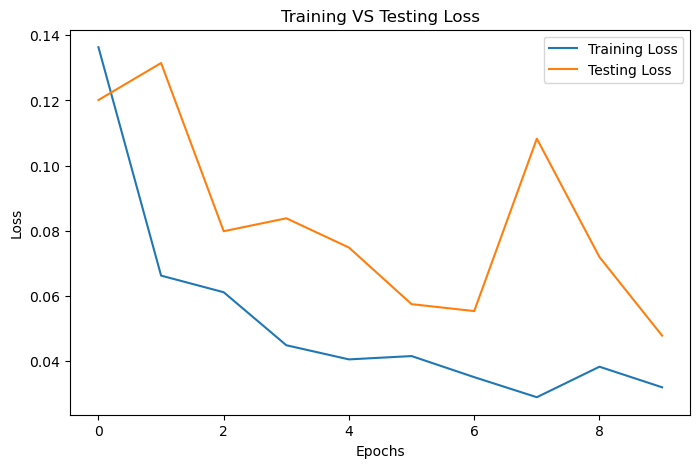

In [89]:
# epochs = range(len(model_1_results['training_loss']))

# plt.figure(figsize=(8, 5))
# plt.plot(epochs, model_1_results['training_loss'], label='Training Loss')
# plt.plot(epochs, model_1_results['testing_loss'], label='Testing Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training VS Testing Loss')
# plt.legend()
# plt.show()

# Clustering

In [91]:
model_1.eval()

with torch.no_grad():
    _, decoder = model_1(X_train_tensor)

latent_np = decoder.cpu().numpy()

In [92]:
wcss = []
silhouette_scores = []
k_range = range(2,11)

In [ ]:
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(latent_np)
    
    wcss.append(kmeans.inertia_)  # Inertia = WCSS
    silhouette_scores.append(silhouette_score(latent_np, labels))

In [ ]:
jhbg fcdxfgcjbhnkml

# Recommending 5 Top Clients (Based on Loyalty)

In [ ]:
X_train.columns

In [ ]:
company_pref = {
    'Age' : 22
}

In [ ]:
company_pref_df = pd.DataFrame([company_pref])
type(company_pref_df)

In [ ]:
company_pref_transformed = preprocessing_pipeline.transform(company_pref_df)
type(company_pref_transformed)

In [ ]:
company_pref_tensor = torch.tensor(company_pref_transformed, torch.float32)
type(company_pref_tensor)

In [ ]:
company_pref_tensor.shape, X_test_tensor.shape